In [1]:
# original, pretrained, finetuned 1장씩 비교
# pretrained model 6
from compressai.zoo import cheng2020_attn
from matplotlib import pyplot as plt
import torch
from dataset import get_datasets
from transforms import get_ori_transform, get_train_transform
from config import device
import io
from PIL import Image
import numpy as np
from astropy.io import fits

def unpreprocess(maxv_log, minv_log, res_img):
    res_img = res_img[0][0] # (B,3,H,W) -> (H,W)
    res_img = res_img * (maxv_log - minv_log) + minv_log
    res_img = torch.expm1(res_img)
    return res_img

def byte_scale(img):
    img_min = img.min()
    img_max = img.max()
    scaled_img = (img - img_min) / (img_max - img_min) * 255.0
    return np.clip(scaled_img, 0, 255).astype(np.uint8)

def de_scale(maxv,minv, out):
    res = (out / 255.0) * (maxv - minv) + minv
    return res

def compress_jpeg(img, quality):
    """Compress image using JPEG with specified quality"""
    # Convert to uint8 for JPEG compression
    img = byte_scale(img)
    
    # Compress using PIL
    img_pil = Image.fromarray(img)
    buffer = io.BytesIO()
    img_pil.save(buffer, format='JPEG', quality=quality)
    compressed_size = buffer.tell()
    
    # Decompress
    buffer.seek(0)
    decompressed = Image.open(buffer)
    decompressed = np.array(decompressed)
    
    # Scale back to original range
    decompressed = (decompressed / 255.0 * (img.max() - img.min()) + img.min()).astype(np.int16)
    
    return compressed_size, decompressed

def compress_rice(data):
    """Compress image using RICE compression"""
    data = byte_scale(data)
    compressed_hdu = fits.CompImageHDU(data=data, compression_type='RICE_1', tile_shape=(256,256))
    with io.BytesIO() as buffer:
        compressed_hdu.writeto(buffer)
        compressed_size = buffer.tell()
        buffer.seek(0)
        
    restored = compressed_hdu.data
    # restored = restored[np.newaxis, np.newaxis, ...] # (1, 1, height, width)

    return compressed_size, restored

ori_transform = get_ori_transform()
transform = get_train_transform()
data1024_filename = 'data1024lst.txt'

_, _, test_set = get_datasets(data1024_filename, transform=transform)
_, _, _test_set = get_datasets(data1024_filename, transform=ori_transform)

model_pt6= cheng2020_attn(pretrained=True, quality=6).to(device).eval()

# finetuned model 갖고오기
model_finetuned = cheng2020_attn(pretrained=False, quality=6)
checkpoint = torch.load("best_model4.pth", map_location=device)
model_finetuned.load_state_dict(checkpoint, strict=True)
model_finetuned = model_finetuned.to(device)
model_finetuned.eval()

Cheng2020Attention(
  (entropy_bottleneck): EntropyBottleneck(
    (likelihood_lower_bound): LowerBound()
    (matrices): ParameterList(
        (0): Parameter containing: [torch.float32 of size 192x3x1 (cuda:2)]
        (1): Parameter containing: [torch.float32 of size 192x3x3 (cuda:2)]
        (2): Parameter containing: [torch.float32 of size 192x3x3 (cuda:2)]
        (3): Parameter containing: [torch.float32 of size 192x3x3 (cuda:2)]
        (4): Parameter containing: [torch.float32 of size 192x1x3 (cuda:2)]
    )
    (biases): ParameterList(
        (0): Parameter containing: [torch.float32 of size 192x3x1 (cuda:2)]
        (1): Parameter containing: [torch.float32 of size 192x3x1 (cuda:2)]
        (2): Parameter containing: [torch.float32 of size 192x3x1 (cuda:2)]
        (3): Parameter containing: [torch.float32 of size 192x3x1 (cuda:2)]
        (4): Parameter containing: [torch.float32 of size 192x1x1 (cuda:2)]
    )
    (factors): ParameterList(
        (0): Parameter containin

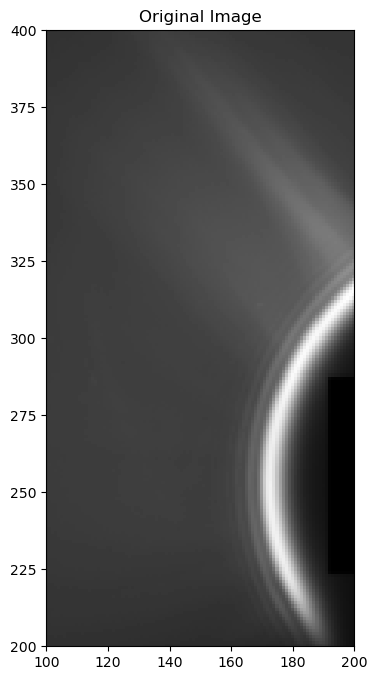

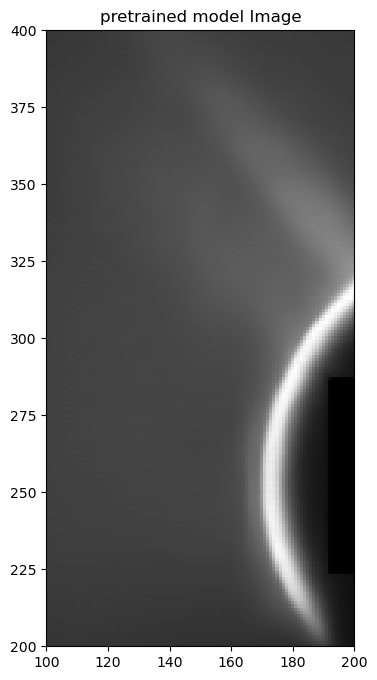

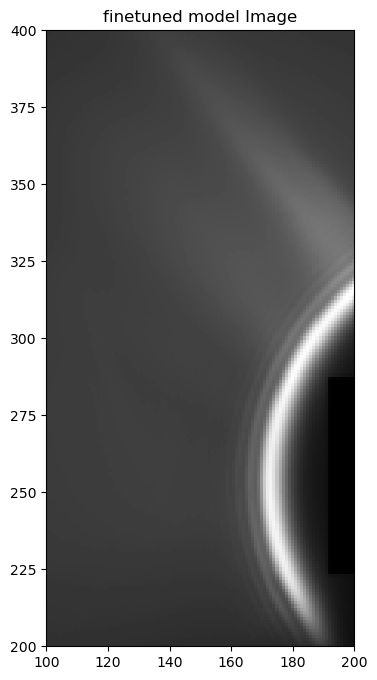

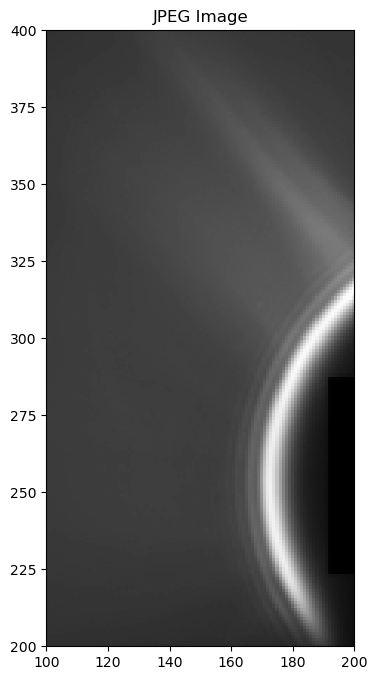

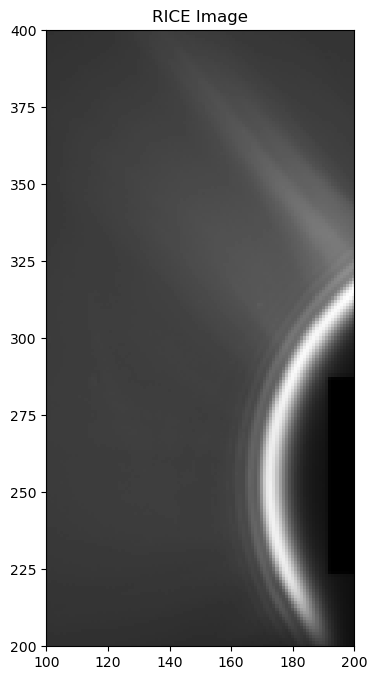

In [3]:
idx = 500
img_or = _test_set[idx][0] # original
log_ori = torch.log1p(torch.clamp(img_or,min=0))
maxv_log = log_ori.max()
minv_log = log_ori.min()

# model
output_pt6 = model_pt6(test_set[idx].unsqueeze(0).to(device))
output_ft = model_finetuned(test_set[idx].unsqueeze(0).to(device))
img_pt6 =unpreprocess(maxv_log=maxv_log, minv_log=minv_log, res_img=output_pt6['x_hat']).squeeze(0).cpu() # pretrained
img_ft = unpreprocess(maxv_log=maxv_log, minv_log=minv_log, res_img=output_ft['x_hat']).squeeze(0).cpu() # finetuned

# jpeg
image = _test_set[idx].squeeze().cpu().numpy()
maxv, minv = image.max(), image.min()
quality = 100
_, jpeg_decompressed = compress_jpeg(image, quality)
jpeg_decompressed = de_scale(maxv, minv, jpeg_decompressed)

# rice
_, rice_decompressed = compress_rice(image)
rice_decompressed = de_scale(maxv, minv, rice_decompressed)

# 이미지 확대
xlim = [100,200]
ylim = [200,400]
plt.figure(figsize=(12,8))
plt.imshow(img_or.cpu().numpy(),origin='lower', cmap='gray')
plt.xlim(xlim)
plt.ylim(ylim)
# plt.colorbar(label='Intensity')  # 컬러바 추가 (데이터 값의 강도 표시)
plt.title('Original Image')
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
plt.show()

plt.figure(figsize=(12,8))
plt.imshow(img_pt6.detach().numpy(),origin='lower', cmap='gray')
plt.xlim(xlim)
plt.ylim(ylim)
# plt.colorbar(label='Intensity')  # 컬러바 추가 (데이터 값의 강도 표시)
plt.title('pretrained model Image')
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
plt.show()

plt.figure(figsize=(12,8))
plt.imshow(img_ft.detach().numpy(),origin='lower', cmap='gray')
plt.xlim(xlim)
plt.ylim(ylim)
# plt.colorbar(label='Intensity')  # 컬러바 추가 (데이터 값의 강도 표시)
plt.title('finetuned model Image')
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
plt.show()

plt.figure(figsize=(12,8))
plt.imshow(jpeg_decompressed,origin='lower', cmap='gray')
plt.xlim(xlim)
plt.ylim(ylim)
# plt.colorbar(label='Intensity')  # 컬러바 추가 (데이터 값의 강도 표시)
plt.title('JPEG Image')
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
plt.show()

plt.figure(figsize=(12,8))
plt.imshow(rice_decompressed,origin='lower', cmap='gray')
plt.xlim(xlim)
plt.ylim(ylim)
# plt.colorbar(label='Intensity')  # 컬러바 추가 (데이터 값의 강도 표시)
plt.title('RICE Image')
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
plt.show()

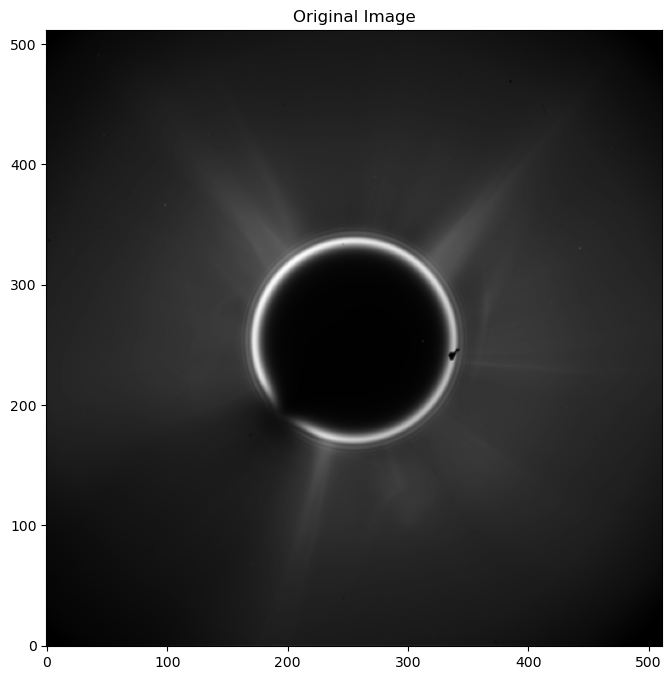

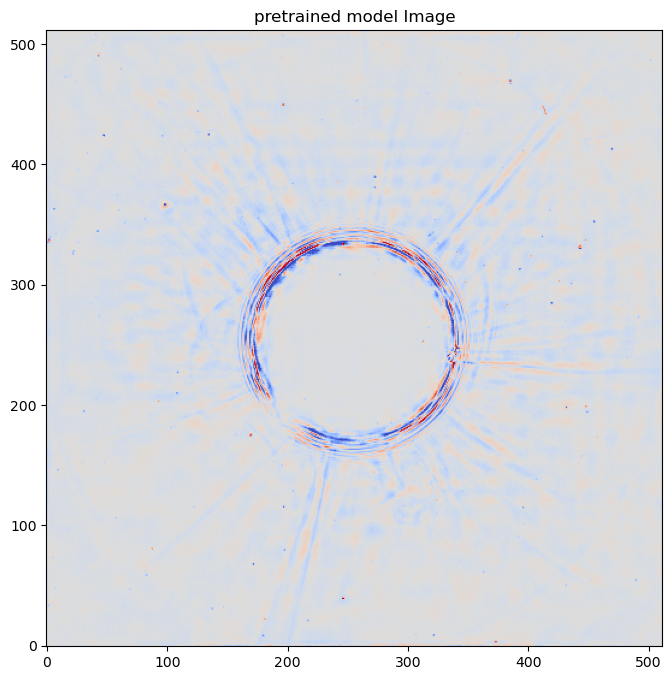

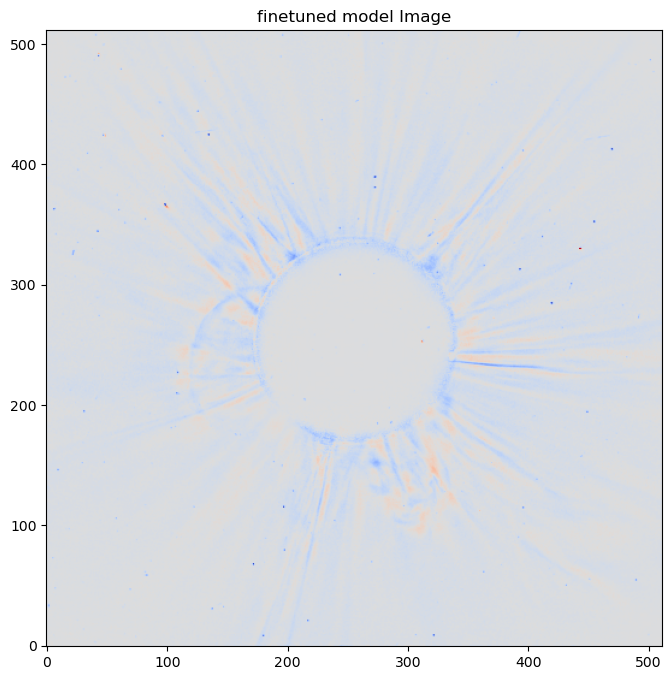

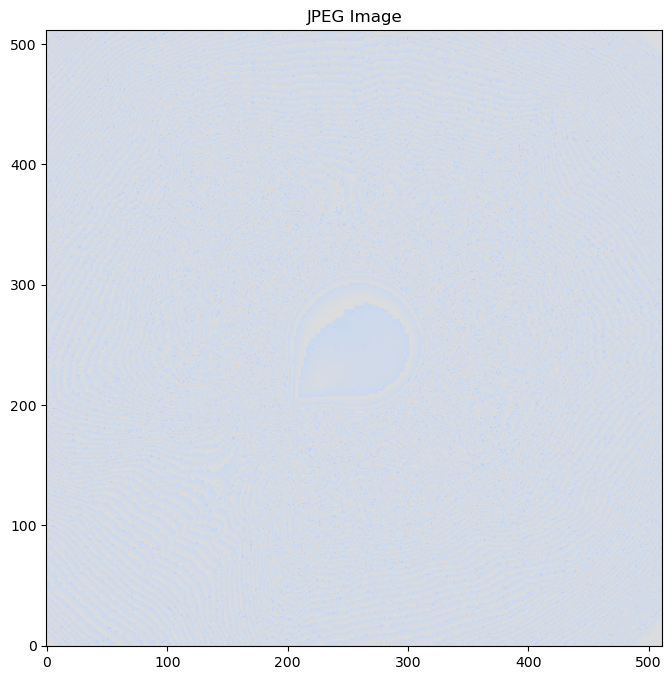

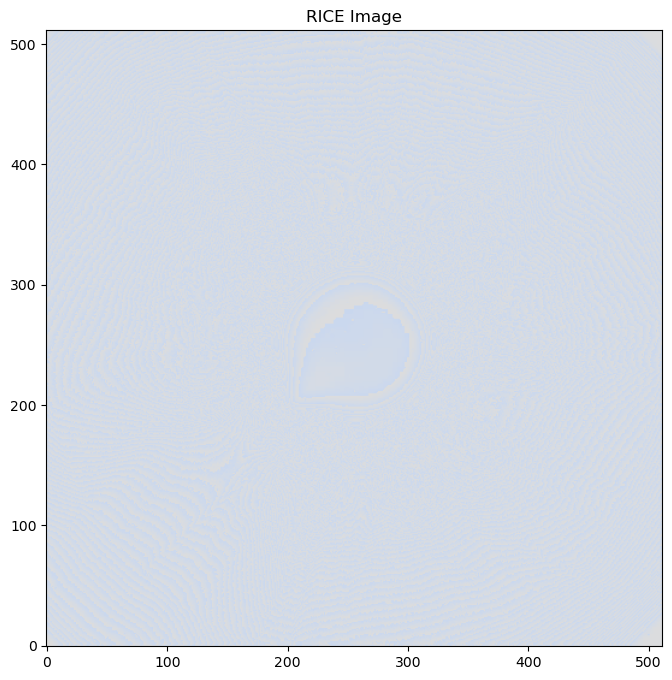

In [16]:
idx = 23
# 500
img_or = _test_set[idx][0] # original
log_ori = torch.log1p(torch.clamp(img_or,min=0))
maxv_log = log_ori.max()
minv_log = log_ori.min()

# model
output_pt6 = model_pt6(test_set[idx].unsqueeze(0).to(device))
output_ft = model_finetuned(test_set[idx].unsqueeze(0).to(device))
img_pt6 =unpreprocess(maxv_log=maxv_log, minv_log=minv_log, res_img=output_pt6['x_hat']).squeeze(0).cpu() # pretrained
img_ft = unpreprocess(maxv_log=maxv_log, minv_log=minv_log, res_img=output_ft['x_hat']).squeeze(0).cpu() # finetuned

# jpeg
image = _test_set[idx].squeeze().cpu().numpy()
maxv, minv = image.max(), image.min()
quality = 100
_, jpeg_decompressed = compress_jpeg(image, quality)
jpeg_decompressed = de_scale(maxv, minv, jpeg_decompressed)

# rice
_, rice_decompressed = compress_rice(image)
rice_decompressed = de_scale(maxv, minv, rice_decompressed)

# 이미지 확대
xlim = [200,400]
ylim = [450,800]
vmax = 400
vmin = -400
plt.figure(figsize=(12,8))
plt.imshow(img_or.cpu().numpy(),origin='lower', cmap='gray')
# plt.xlim(xlim)
# plt.ylim(ylim)
# plt.colorbar(label='Intensity')  # 컬러바 추가 (데이터 값의 강도 표시)
plt.title('Original Image')
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
plt.show()

plt.figure(figsize=(12,8))
plt.imshow(img_pt6.detach().numpy() - img_or.cpu().numpy(),origin='lower', cmap='coolwarm', vmin=vmin, vmax= vmax)
# plt.xlim(xlim)
# plt.ylim(ylim)
# plt.colorbar(label='Intensity')  # 컬러바 추가 (데이터 값의 강도 표시)
plt.title('pretrained model Image')
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
plt.show()

plt.figure(figsize=(12,8))
plt.imshow(img_ft.detach().numpy() - img_or.cpu().numpy(),origin='lower', cmap='coolwarm', vmin=vmin, vmax= vmax)
# plt.xlim(xlim)
# plt.ylim(ylim)
# plt.colorbar(label='Intensity')  # 컬러바 추가 (데이터 값의 강도 표시)
plt.title('finetuned model Image')
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
plt.show()

plt.figure(figsize=(12,8))
plt.imshow(jpeg_decompressed - img_or.cpu().numpy(), origin='lower', cmap='coolwarm', vmin=vmin, vmax= vmax)
# plt.xlim(xlim)
# plt.ylim(ylim)
# plt.colorbar(label='Intensity')  # 컬러바 추가 (데이터 값의 강도 표시)
plt.title('JPEG Image')
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
plt.show()

plt.figure(figsize=(12,8))
plt.imshow(rice_decompressed - img_or.cpu().numpy(),origin='lower', cmap='coolwarm', vmin=vmin, vmax= vmax)
# plt.xlim(xlim)
# plt.ylim(ylim)
# plt.colorbar(label='Intensity')  # 컬러바 추가 (데이터 값의 강도 표시)
plt.title('RICE Image')
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
plt.show()